In [13]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума ${\epsilon}$:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$.

In [ ]:
x_min = 0
x_max = 3
N_points = 2000
# Случайный набор X-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), np.array([[-5, 2, -3, 1]])), '--', color='black')
plt.legend(['train dataset', 'exact trend line', 'poly line'])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/dataset_plot.png')
plt.show

In [14]:
np.random.seed(42)
n = 100
x = np.linspace(-2, 2, n)
y_true = 2 + 3*x + 1.5*x**2 - 0.5*x**3
y = y_true + np.random.normal(0, 1, n)  # добавляем шум

In [ ]:
from functions.functions_under_study import grad_well, grad_poor, grad_rozen
from functions.optimization import momentum, nesterov, adagrad, adadelta, rmsprop, adam

In [19]:
def newton_method(X, y, w0, max_iter=100, tol=1e-6):
    w = w0.copy()
    losses = [loss(w, X, y)]
    
    for i in range(max_iter):
        grad = gradient(w, X, y)
        H = hessian(w, X, y)
        
        # Проверка положительной определённости (для Холецкого)
        try:
            c, low = cho_factor(H)
            dw = cho_solve((c, low), -grad)
        except np.linalg.LinAlgError:
            print("Гессиан не положительно определён, используем градиентный шаг")
            dw = -grad  # fallback на градиентный спуск
        
        w_new = w + dw
        loss_new = loss(w_new, X, y)
        losses.append(loss_new)
        
        if np.linalg.norm(dw) < tol:
            print(f"Метод Ньютона сошёлся на итерации {i+1}")
            break
            
        w = w_new
        
    return w, losses

In [20]:
def gauss_newton_method(X, y, w0, max_iter=100, tol=1e-6):
    w = w0.copy()
    losses = [loss(w, X, y)]
    
    for i in range(max_iter):
        r = X @ w - y  # остатки
        J = jacobian(w, X, y)  # Якобиан = X
        
        # Система: (J^T J) dw = -J^T r
        try:
            H_gn = J.T @ J
            g_gn = J.T @ r
            c, low = cho_factor(H_gn)
            dw = cho_solve((c, low), -g_gn)
        except np.linalg.LinAlgError:
            print("Матрица J^T J не положительно определена, используем градиент")
            dw = -gradient(w, X, y)
        
        w_new = w + dw
        loss_new = loss(w_new, X, y)
        losses.append(loss_new)
        
        if np.linalg.norm(dw) < tol:
            print(f"Гаусс-Ньютон сошёлся на итерации {i+1}")
            break
            
        w = w_new
        
    return w, losses

In [21]:
def quasi_newton_method(X, y, w0, method='BFGS', max_iter=100, tol=1e-6):
    w = w0.copy()
    n_params = len(w)
    losses = [loss(w, X, y)]
    
    # Инициализация обратного гессиана (или его приближения)
    if method == 'DFP' or method == 'BFGS':
        H_inv = np.eye(n_params)  # начальное приближение — единичная матрица
    else:
        raise ValueError("Метод должен быть 'DFP' или 'BFGS'")
    
    for i in range(max_iter):
        grad = gradient(w, X, y)
        if np.linalg.norm(grad) < tol:
            print(f"{method} сошёлся по градиенту на итерации {i+1}")
            break
            
        # Направление поиска
        p = -H_inv @ grad
        
        # Выбираем шаг (для простоты — фиксированный, можно добавить лин. поиск)
        alpha = 1.0
        w_new = w + alpha * p
        
        # Обновляем градиент
        grad_new = gradient(w_new, X, y)
        s = w_new - w  # s = w_{k+1} - w_k
        y_vec = grad_new - grad  # y = ∇f_{k+1} - ∇f_k
        
        # Проверка условия кривизны
        if np.dot(s, y_vec) <= 1e-10:
            print("Пропуск обновления — условие кривизны не выполнено")
            w = w_new
            losses.append(loss(w, X, y))
            continue
        
        # Обновление H_inv по формулам DFP или BFGS
        if method == 'DFP':
            # DFP update:
            # H_{k+1} = H_k - (H_k y y^T H_k)/(y^T H_k y) + (s s^T)/(s^T y)
            Hy = H_inv @ y_vec
            term1 = np.outer(Hy, Hy) / np.dot(y_vec, Hy)
            term2 = np.outer(s, s) / np.dot(s, y_vec)
            H_inv = H_inv - term1 + term2
            
        elif method == 'BFGS':
            # BFGS update:
            # H_{k+1} = (I - ρ s y^T) H_k (I - ρ y s^T) + ρ s s^T, где ρ = 1/(y^T s)
            rho = 1.0 / np.dot(y_vec, s)
            I = np.eye(n_params)
            V = I - rho * np.outer(s, y_vec)
            H_inv = V.T @ H_inv @ V + rho * np.outer(s, s)
        
        w = w_new
        losses.append(loss(w, X, y))
        
        if np.linalg.norm(s) < tol:
            print(f"{method} сошёлся по шагу на итерации {i+1}")
            break
            
    return w, losses

In [ ]:
degree = 3
X = polynomial_features(x, degree)
w0 = np.zeros(degree + 1)  # начальные веса — нули

# Запуск методов
w_newton, losses_newton = newton_method(X, y, w0)
w_gn, losses_gn = gauss_newton_method(X, y, w0)
w_dfp, losses_dfp = quasi_newton_method(X, y, w0, method='DFP')
w_bfgs, losses_bfgs = quasi_newton_method(X, y, w0, method='BFGS')

print("\n--- Итоговые веса ---")
print("Ньютон:      ", w_newton)
print("Гаусс-Ньютон:", w_gn)
print("DFP:         ", w_dfp)
print("BFGS:        ", w_bfgs)
print("Истинные:    ", [2, 3, 1.5, -0.5])

Метод Ньютона сошёлся на итерации 2
Гаусс-Ньютон сошёлся на итерации 2
Пропуск обновления — условие кривизны не выполнено
DFP сошёлся по градиенту на итерации 40

--- Итоговые веса ---
Ньютон:       [ 1.94220673  3.38453911  1.28012346 -0.61334215  0.07598387 -0.01017311]
Гаусс-Ньютон: [ 1.94220673  3.38453911  1.28012346 -0.61334215  0.07598387 -0.01017311]
DFP:          [ 1.9422066   3.38453978  1.28012376 -0.61334278  0.07598379 -0.01017298]
BFGS:         [nan nan nan nan nan nan]
Истинные:     [2, 3, 1.5, -0.5]


c:\Users\g5059\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:925: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
C:\Users\g5059\AppData\Local\Temp\ipykernel_34628\959534133.py:51: RuntimeWarning: invalid value encountered in multiply
  V = I - rho * np.outer(s, y_vec)
C:\Users\g5059\AppData\Local\Temp\ipykernel_34628\2845997008.py:5: RuntimeWarning: overflow encountered in square
  return 0.5 * np.sum(residuals**2) / n


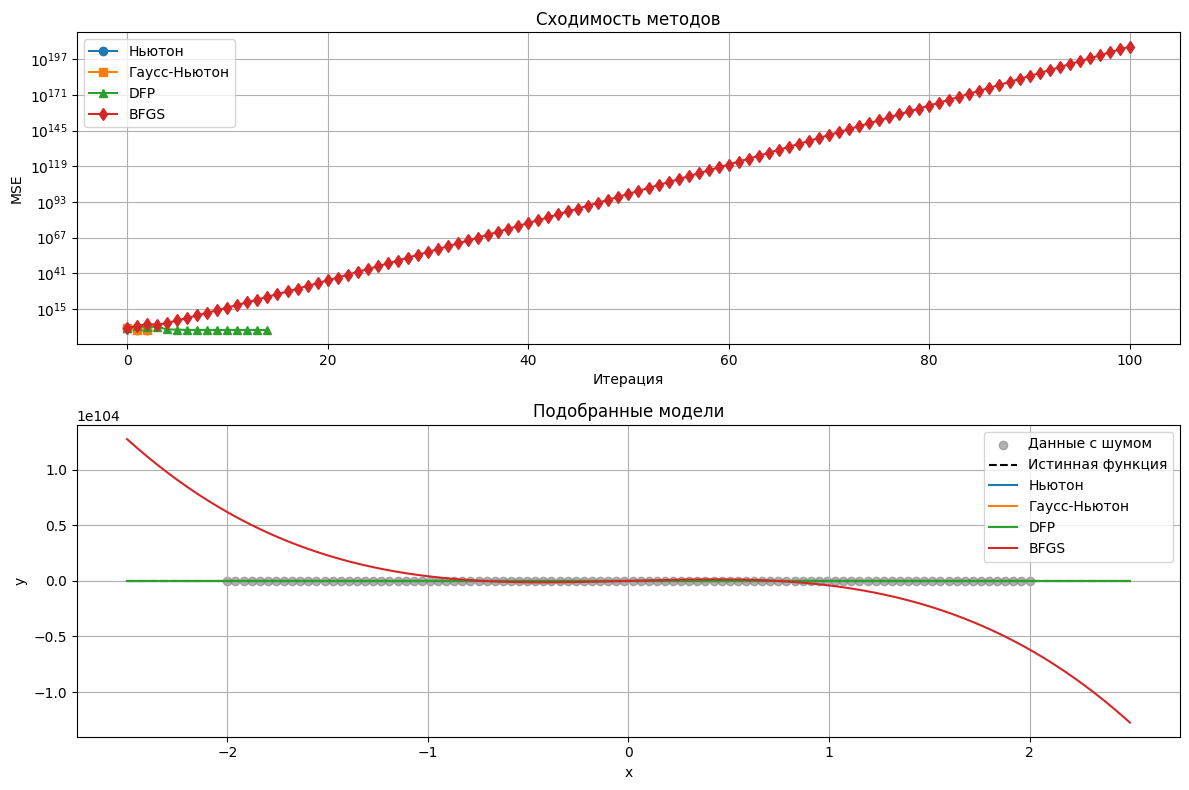

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(losses_newton, label='Ньютон', marker='o')
plt.plot(losses_gn, label='Гаусс-Ньютон', marker='s')
plt.plot(losses_dfp, label='DFP', marker='^')
plt.plot(losses_bfgs, label='BFGS', marker='d')
plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.title('Сходимость методов')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
x_plot = np.linspace(-2.5, 2.5, 200)
X_plot = polynomial_features(x_plot, degree)
y_plot_newton = predict(X_plot, w_newton)
y_plot_gn = predict(X_plot, w_gn)
y_plot_dfp = predict(X_plot, w_dfp)
y_plot_bfgs = predict(X_plot, w_bfgs)
y_true_plot = 2 + 3*x_plot + 1.5*x_plot**2 - 0.5*x_plot**3

plt.scatter(x, y, color='gray', alpha=0.6, label='Данные с шумом')
plt.plot(x_plot, y_true_plot, 'k--', label='Истинная функция')
plt.plot(x_plot, y_plot_newton, label='Ньютон')
plt.plot(x_plot, y_plot_gn, label='Гаусс-Ньютон')
plt.plot(x_plot, y_plot_dfp, label='DFP')
plt.plot(x_plot, y_plot_bfgs, label='BFGS')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Подобранные модели')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_4, color='green', linestyle='-', linewidth=2)
plt.plot(losses_5, color='brown', linestyle='--', linewidth=1)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,500)
plt.legend(['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
            'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.8',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.4',
            'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show

In [ ]:
legend_list =  ['lr=[5e-7, 5e-7, 5e-7, 5e-7, 5e-7], batch=1.0, beta=0.0',
                'lr=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9], batch=1.0, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.1, beta=0.0',
                'lr=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], batch=0.2, beta=0.0']

plt.plot(losses_1, color='magenta', linestyle='--', linewidth=2)
plt.plot(losses_2, color='orange', linestyle='-.', linewidth=2)
plt.plot(losses_3, color='blue', linestyle='--', linewidth=2)
plt.plot(losses_6, color='red', linestyle=':', linewidth=2)
plt.ylim(70,500)
plt.legend(legend_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('plots/MSE_plot.png')
plt.show

In [ ]:
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='yellow')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_1), color='magenta', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_2), color='orange', linestyle='-.', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_3), color='blue', linestyle='--', linewidth=2)
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_6), color='red', linestyle=':', linewidth=2)
plt.legend(['train dataset', 'exact trend line'] + legend_list)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plots/trend_line_plot.png')
plt.show

In [ ]:
fit_time = [fit_time_1, fit_time_2, fit_time_3, fit_time_6]
bar_label = ['Opt. 1', 'Opt. 2', 'Opt. 3', 'Opt. 6']
bar_colors = ['magenta', 'orange', 'blue', 'red']
plt.bar(bar_label, fit_time, color=bar_colors)
plt.ylabel('Time, sec.')
plt.savefig('plots/time_plot.png')
plt.show